In [107]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1650 (UUID: GPU-f010ab2c-9f8a-dfc2-d888-045d09377d67)


## Get a text dataset

In [108]:
import zipfile

def unzip_data(filename):
    zip_ref = zipfile.ZipFile(filename, "r")
    zip_ref.extractall()
    zip_ref.close()

In [109]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

unzip_data("nlp_getting_started.zip")

'wget' is not recognized as an internal or external command,
operable program or batch file.


## Visualizing a text dataset

In [110]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [111]:
train_df["text"][:10]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
5    #RockyFire Update => California Hwy. 20 closed...
6    #flood #disaster Heavy rain causes flash flood...
7    I'm on top of the hill and I can see a fire in...
8    There's an emergency evacuation happening now ...
9    I'm afraid that the tornado is coming to our a...
Name: text, dtype: object

In [112]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [113]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [114]:
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [115]:
len(train_df), len(test_df)

(7613, 3263)

In [116]:
import random

random_index = random.randint(0, len(train_df)-5)  # Create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
    _, text, target = row
    print(f"Target {target}", "(real disaster)" if target > 0 else "(not real diaster)")
    print(f"Text:\n{text}\n")
    print(f"---\n")

Target 0 (not real diaster)
Text:
Calgary news weather and traffic for August 5 * ~ 45 http://t.co/zAGBMlSf4H http://t.co/HVYXehXBmq

---

Target 1 (real disaster)
Text:
Rly tragedy in MP: Some live to recount horror: ÛÏWhen I saw coaches of my train plunging into water I called ... http://t.co/ZkgQSpwYj3

---

Target 1 (real disaster)
Text:
Gail and Russell saw lots of hail at their Dalroy home - they have video of twister 1/2 mile from their home #yyc http://t.co/3VfKEdGrsO

---

Target 1 (real disaster)
Text:
real magic in real life:

women went missing in Ohio town the focus of FBI probe after strange deaths and... http://t.co/6m0YNJWbc9

---

Target 1 (real disaster)
Text:
Find out how your fund was used for Typhoon Haiyan in the Philippines. See @DevPeace Haiyan Relief Funds Report http://t.co/JwxrX1LsqO

---



### Split data into trianing and validation sets

In [117]:
from sklearn.model_selection import train_test_split

In [118]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [119]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [120]:
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Text vectorization (tokenization)

In [121]:
import tensorflow as tf
print(tf.__version__)

2.16.1


In [122]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=None,
                                 standardize="lower_and_strip_punctuation",
                                 split="whitespace",
                                 ngrams=None,
                                 output_mode="int",  # how to map tokens to numebers
                                 output_sequence_length=None)

In [123]:
# Find average number of tokens
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [124]:
# Setup text vectorization with custom variables
max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_sequence_length=max_length)

In [125]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [126]:
sample_sentence = "There's a Wall Street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 264,    3, 1104,  698,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]], dtype=int64)>

In [127]:
# Chose a random sentence from training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
\n\nVectorized version:\n {text_vectorizer([random_sentence])}")

Original text:
@SergioPiaggio 'IÛªd worked so hard to get to that level that I wasnÛªt going to let the injury define me. I was going to define it.Û Cool

Vectorized version:
 [[8643 5331 1733   28  892    5   52    5   16  813   16    8 6913  104
     5]]


In [128]:
# Get the unique words in the vocab
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [156]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             name="embedding_1")
embedding

<Embedding name=embedding_1, built=False>

In [130]:
random_sentence = random.choice(train_sentences)
print(f"Original first word from sentence: {random_sentence}")
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original first word from sentence: @rvfriedmann Hell is just a fraction of his belief of total annihilation destruction of USA @LodiSilverado @ritzy_jewels


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.04719618, -0.00459682, -0.0193726 , ...,  0.00415983,
         -0.01084596,  0.02772203],
        [-0.01898601, -0.00635307,  0.02797418, ...,  0.03733797,
         -0.01081629,  0.04132548],
        [-0.02249317,  0.0268094 ,  0.02275301, ...,  0.01507053,
         -0.04882738, -0.03161124],
        ...,
        [-0.02759   ,  0.00053876, -0.03734253, ..., -0.04352731,
          0.04424325,  0.03108192],
        [-0.03633182,  0.02368027, -0.00386846, ...,  0.03458328,
          0.00217859, -0.01466639],
        [ 0.04344279, -0.02013401, -0.02754755, ..., -0.01828521,
         -0.01613609, -0.02524475]]], dtype=float32)>

In [131]:
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.04719618, -0.00459682, -0.0193726 , -0.04575532, -0.04705371,
       -0.01772636,  0.04240766,  0.01347368,  0.04572808, -0.00997768,
        0.0409639 , -0.01205205,  0.0413007 , -0.02368424,  0.02290291,
        0.00225236, -0.04627881,  0.02849011,  0.03480132,  0.04201751,
        0.02854199,  0.0303761 ,  0.03712216, -0.00644326,  0.04531765,
        0.02472628,  0.03833282, -0.00234719, -0.03500308, -0.01424401,
       -0.02806574,  0.03092018, -0.00851681,  0.03479368,  0.0043514 ,
        0.04382128,  0.04394275,  0.00687019, -0.02382776, -0.01983422,
       -0.0288734 ,  0.01068193,  0.04065944, -0.01261269,  0.00154122,
        0.04476596, -0.03450545,  0.03631009, -0.00550183, -0.02418547,
        0.02214492,  0.03373196, -0.03216227,  0.00464935, -0.02680966,
        0.03040414, -0.0305234 , -0.03128681, -0.00378314, -0.00313057,
       -0.00481651, -0.00624529, -0.0245994 , -0.03509324,  0.04745121,
       -0.041070

In [132]:
len(sample_embed[0][0])

128

### Following models:
* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model
* Model 3: GRU model
* Model 4: Bidirectional-LSTM model
* Model 5: 1D Convolutional Neural Network
* Model 6: TensorFlow Hub Pretrained Feature Extractor
* Model 7: Same as model 6 with 10% of training data

### Each experiment will go through the following steps:
* Construct the model
* Train the model
* Make predictions with the model
* Track prediction evaluation metrics for later comparison

In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
    ("clf", MultinomialNB()), # model the text
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [134]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [135]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype=int64)

In [136]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
    Args:
    y_true = true labels in the form of a 1D array
    y_pred = predicted labels in the form of a 1D array

    Return a dictionary of accuracy, precision, recall, f1-score.
    """
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                    "precision": model_precision,
                    "recall": model_recall,
                    "f1": model_f1}
    return model_results

In [137]:
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [138]:
from helper_functions import create_tensorboard_callback

SAVE_DIR = "model_logs"

In [139]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [140]:
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [141]:
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_4            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [142]:
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20240415-194109
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6337 - loss: 0.6505 - val_accuracy: 0.7585 - val_loss: 0.5347
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8074 - loss: 0.4673 - val_accuracy: 0.7887 - val_loss: 0.4742
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8526 - loss: 0.3629 - val_accuracy: 0.7900 - val_loss: 0.4621
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8854 - loss: 0.2965 - val_accuracy: 0.7887 - val_loss: 0.4682
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9064 - loss: 0.2477 - val_accuracy: 0.7795 - val_loss: 0.4839


In [143]:
model_1.evaluate(val_sentences, val_labels)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7685 - loss: 0.5160 


[0.48389124870300293, 0.7795275449752808]

In [144]:
embedding.weights

[<KerasVariable shape=(10000, 128), dtype=float32, path=embedding_1/embeddings>]

In [145]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


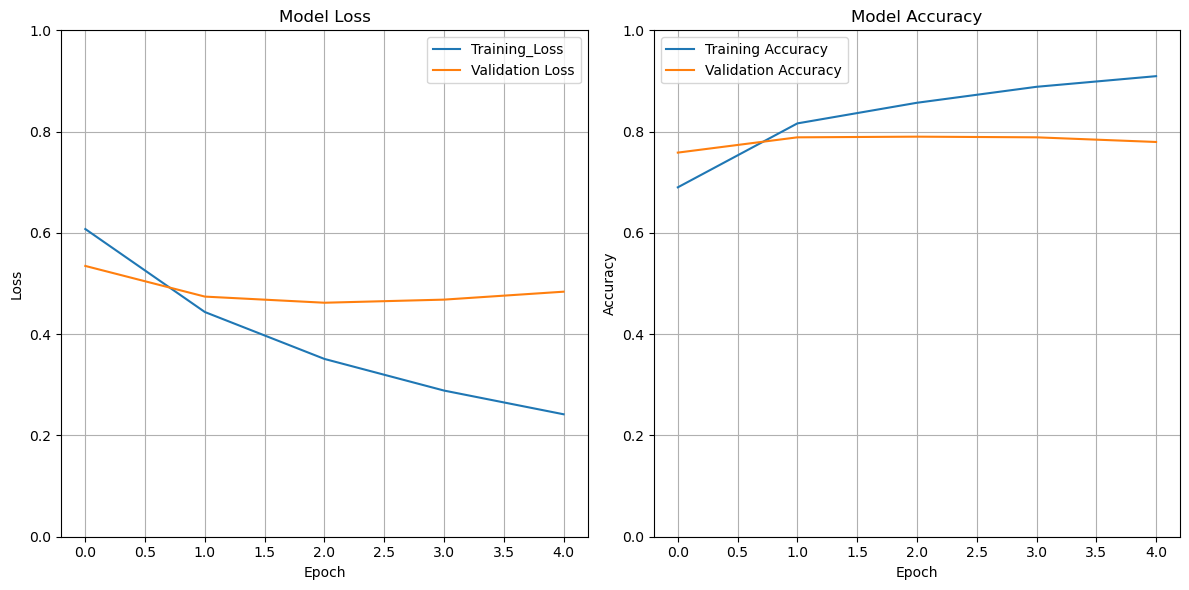

In [146]:
import matplotlib.pyplot as plt

def plot_training_history(model_history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.plot(model_history.history['loss'], label="Training_Loss")
    ax1.plot(model_history.history['val_loss'], label="Validation Loss")
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid()
    ax1.legend()
    ax1.set_ylim(0, 1)
    
    ax2.plot(model_history.history['accuracy'], label="Training Accuracy")
    ax2.plot(model_history.history['val_accuracy'], label="Validation Accuracy")
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid()
    ax2.legend()
    ax2.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

plot_training_history(model_history=model_1_history)

In [147]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


array([[0.3400634 ],
       [0.7341221 ],
       [0.99757314],
       [0.18652119],
       [0.10877017],
       [0.94332564],
       [0.88981175],
       [0.9943257 ],
       [0.9609261 ],
       [0.37742212]], dtype=float32)

In [148]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [149]:
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 77.95275590551181,
 'precision': 0.7825962002002497,
 'recall': 0.7795275590551181,
 'f1': 0.7770045099502749}

In [150]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [151]:
def compare_baseline_to_new_results(baseline_results, new_model_results):
    for key, value in baseline_results.items():
        print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 77.95, Difference: -1.31
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


In [152]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [153]:
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_4            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,840,389 (14.65 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,560,260 (9.77 MB)

In [154]:
# Get the weight matrix of mebedding layer
# (these are the numerical patterns between the text in the training dataset the model has learned)
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [157]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     name="embedding_2")
# LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
x = layers.LSTM(64)(x)
print(x.shape)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [158]:
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [159]:
model_2.summary()

Model: "model_2_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_4            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,333,633 (5.09 MB)

 Trainable params: 1,333,633 (5.09 MB)

 Non-trainable params: 0 (0.00 B)

In [160]:
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20240415-194843
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6715 - loss: 0.5858 - val_accuracy: 0.7730 - val_loss: 0.4619
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8624 - loss: 0.3337 - val_accuracy: 0.7625 - val_loss: 0.5150
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9144 - loss: 0.2223 - val_accuracy: 0.7520 - val_loss: 0.6822
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9537 - loss: 0.1302 - val_accuracy: 0.7520 - val_loss: 0.7155
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9642 - loss: 0.1109 - val_accuracy: 0.7638 - val_loss: 0.7773


In [161]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


((762, 1),
 array([[0.1438611 ],
        [0.98228717],
        [0.99973464],
        [0.02266973],
        [0.01230812],
        [0.9977659 ],
        [0.34710371],
        [0.9997544 ],
        [0.99833673],
        [0.55962527]], dtype=float32))

In [162]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [166]:
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 76.37795275590551,
 'precision': 0.7676775517210905,
 'recall': 0.7637795275590551,
 'f1': 0.7604572192804401}

In [167]:
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 76.38, Difference: -2.89
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


In [169]:
# GRU model
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     name="embedding_3")

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
x = layers.GRU(64)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [171]:
model_3.compile(loss="binary_crossentropy",
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

In [172]:
model_3.summary()

Model: "model_3_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_4            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,321,473 (5.04 MB)

 Trainable params: 1,321,473 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

In [173]:
model_3_history = model_3.fit(train_sentences, 
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20240415-200428
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6457 - loss: 0.6081 - val_accuracy: 0.7848 - val_loss: 0.4572
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8583 - loss: 0.3415 - val_accuracy: 0.7717 - val_loss: 0.5092
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9095 - loss: 0.2316 - val_accuracy: 0.7612 - val_loss: 0.6009
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9433 - loss: 0.1537 - val_accuracy: 0.7677 - val_loss: 0.6385
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9576 - loss: 0.1203 - val_accuracy: 0.7598 - val_loss: 0.7497


In [174]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


((762, 1),
 array([[0.12007144],
        [0.8341522 ],
        [0.99922925],
        [0.03088763],
        [0.00480873],
        [0.9992603 ],
        [0.8212253 ],
        [0.99965566],
        [0.99927485],
        [0.3800403 ]], dtype=float32))

In [175]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [176]:
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 75.98425196850394,
 'precision': 0.7601337255372377,
 'recall': 0.7598425196850394,
 'f1': 0.7583542786286791}

In [177]:
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 75.98, Difference: -3.28
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


In [178]:
# Bidirectional model
tf.random.set_seed(42)
from tensorflow.keras import layers

model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     name="embedding_4")

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [179]:
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [180]:
model_4.summary()

Model: "model_4_Bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_4            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,378,945 (5.26 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [183]:
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20240415-202758
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6800 - loss: 0.5774 - val_accuracy: 0.7795 - val_loss: 0.4627
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8682 - loss: 0.3263 - val_accuracy: 0.7703 - val_loss: 0.5103
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9162 - loss: 0.2201 - val_accuracy: 0.7533 - val_loss: 0.5722
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9510 - loss: 0.1415 - val_accuracy: 0.7546 - val_loss: 0.6430
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9587 - loss: 0.1260 - val_accuracy: 0.7559 - val_loss: 0.7687


In [185]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


array([[0.17151271],
       [0.9428595 ],
       [0.9986239 ],
       [0.04111375],
       [0.00271865],
       [0.98649967],
       [0.64199275],
       [0.99826676],
       [0.9988662 ],
       [0.55738026]], dtype=float32)

In [186]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [187]:
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 75.59055118110236,
 'precision': 0.7555819221227483,
 'recall': 0.7559055118110236,
 'f1': 0.7549846322026649}

In [188]:
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 75.59, Difference: -3.67
Baseline precision: 0.81, New precision: 0.76, Difference: -0.06
Baseline recall: 0.79, New recall: 0.76, Difference: -0.04
Baseline f1: 0.79, New f1: 0.75, Difference: -0.03


In [194]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu")
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [201]:
# Conv1D model
tf.random.set_seed(42)
from tensorflow.keras import layers

model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     name="embedding_5")

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_5.summary()

Model: "model_5_Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_4            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 11, 32)         │        20,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_8          │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,302,689 (4.97 MB)

 Trainable params: 1,302,689 (4.97 MB)

 Non-trainable params: 0 (0.00 B)

In [204]:
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                      "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20240415-205120
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6347 - loss: 0.6309 - val_accuracy: 0.7900 - val_loss: 0.4656
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8500 - loss: 0.3590 - val_accuracy: 0.7795 - val_loss: 0.4896
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9289 - loss: 0.2011 - val_accuracy: 0.7664 - val_loss: 0.5665
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9611 - loss: 0.1181 - val_accuracy: 0.7677 - val_loss: 0.6024
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9748 - loss: 0.0814 - val_accuracy: 0.7677 - val_loss: 0.6441


In [206]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


array([[0.4332126 ],
       [0.80765444],
       [0.9995709 ],
       [0.07962009],
       [0.00848698],
       [0.9923963 ],
       [0.56529534],
       [0.9981356 ],
       [0.9965298 ],
       [0.17346105]], dtype=float32)

In [209]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [210]:
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 76.77165354330708,
 'precision': 0.769927879249698,
 'recall': 0.7677165354330708,
 'f1': 0.7652718344725522}

In [211]:
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 76.77, Difference: -2.49
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


In [222]:
print("tensorflow:", tf.__version__)
print("tensorflow hub:", hub.__version__)

tensorflow: 2.16.1
tensorflow hub: 0.16.1


In [262]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Model

# Define input layer
input_layer = layers.Input(shape=[], dtype=tf.string, name="input_layer")

# Load Universal Sentence Encoder
use_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
use_embed = hub.load(use_url)

# Define a custom layer to wrap the USE function
class USELayer(layers.Layer):
    def __init__(self, **kwargs):
        super(USELayer, self).__init__(**kwargs)

    def call(self, inputs):
        return use_embed(inputs)

# Apply the custom layer to the input
use_embedding = USELayer()(input_layer)

# Define the remaining layers of the model
dense_1 = layers.Dense(64, activation="relu")(use_embedding)
output = layers.Dense(1, activation="sigmoid")(dense_1)

# Create the model
model_6 = Model(inputs=input_layer, outputs=output, name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [263]:
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                      "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20240415-223238
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7459 - loss: 0.5740 - val_accuracy: 0.7979 - val_loss: 0.4526
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8047 - loss: 0.4215 - val_accuracy: 0.8071 - val_loss: 0.4427
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8140 - loss: 0.4074 - val_accuracy: 0.8110 - val_loss: 0.4375
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8161 - loss: 0.3994 - val_accuracy: 0.8110 - val_loss: 0.4340
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8191 - loss: 0.3933 - val_accuracy: 0.8163 - val_loss: 0.4316


In [264]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


array([[0.17462826],
       [0.8028887 ],
       [0.9829293 ],
       [0.18286657],
       [0.7856797 ],
       [0.75600696],
       [0.980391  ],
       [0.9758863 ],
       [0.95050126],
       [0.11677084]], dtype=float32)

In [265]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [266]:
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.8163098416789168,
 'recall': 0.8162729658792651,
 'f1': 0.8157217027284339}

In [267]:
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.63, Difference: 2.36
Baseline precision: 0.81, New precision: 0.82, Difference: 0.01
Baseline recall: 0.79, New recall: 0.82, Difference: 0.02
Baseline f1: 0.79, New f1: 0.82, Difference: 0.03


In [268]:
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                             train_labels,
                                                                                                                             test_size=0.1,
                                                                                                                             random_state=42)

In [269]:
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10%  training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10%  training examples: 686


In [270]:
# Check the number of targets in subnet data
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
Name: count, dtype: int64

In [273]:
# Clone model_6 but reset weights
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Model

# Define input layer
input_layer = layers.Input(shape=[], dtype=tf.string, name="input_layer")

# Load Universal Sentence Encoder
use_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
use_embed = hub.load(use_url)

# Define a custom layer to wrap the USE function
class USELayer(layers.Layer):
    def __init__(self, **kwargs):
        super(USELayer, self).__init__(**kwargs)

    def call(self, inputs):
        return use_embed(inputs)

# Apply the custom layer to the input
use_embedding = USELayer()(input_layer)

# Define the remaining layers of the model
dense_1 = layers.Dense(64, activation="relu")(use_embedding)
output = layers.Dense(1, activation="sigmoid")(dense_1)

# Create the model
model_7 = Model(inputs=input_layer, outputs=output, name="model_6_USE")

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [276]:
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20240415-223627
Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.5991 - loss: 0.6829 - val_accuracy: 0.7428 - val_loss: 0.6435
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8330 - loss: 0.6056 - val_accuracy: 0.7546 - val_loss: 0.5820
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8247 - loss: 0.5268 - val_accuracy: 0.7677 - val_loss: 0.5274
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8206 - loss: 0.4622 - val_accuracy: 0.7756 - val_loss: 0.4978
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8184 - loss: 0.4199 - val_accuracy: 0.7808 - val_loss: 0.4847


In [277]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


array([[0.23593535],
       [0.8013634 ],
       [0.918381  ],
       [0.30319455],
       [0.56564474],
       [0.8519012 ],
       [0.83660007],
       [0.8688234 ],
       [0.8537408 ],
       [0.11379489]], dtype=float32)

In [279]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [281]:
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 78.08398950131233,
 'precision': 0.7848699684611963,
 'recall': 0.7808398950131233,
 'f1': 0.7779792730264676}

In [282]:
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 78.08, Difference: -1.18
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


In [300]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,77.952756,0.782596,0.779528,0.777005
lstm,76.377953,0.767678,0.763780,0.760457
gru,75.984252,0.760134,0.759843,0.758354
bidirectional,75.590551,0.755582,0.755906,0.754985
conv1d,76.771654,0.769928,0.767717,0.765272
tf_hub_sentence_encoder,81.627297,0.816310,0.816273,0.815722
tf_hub_10_percent_data,78.083990,0.784870,0.780840,0.777979


In [301]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

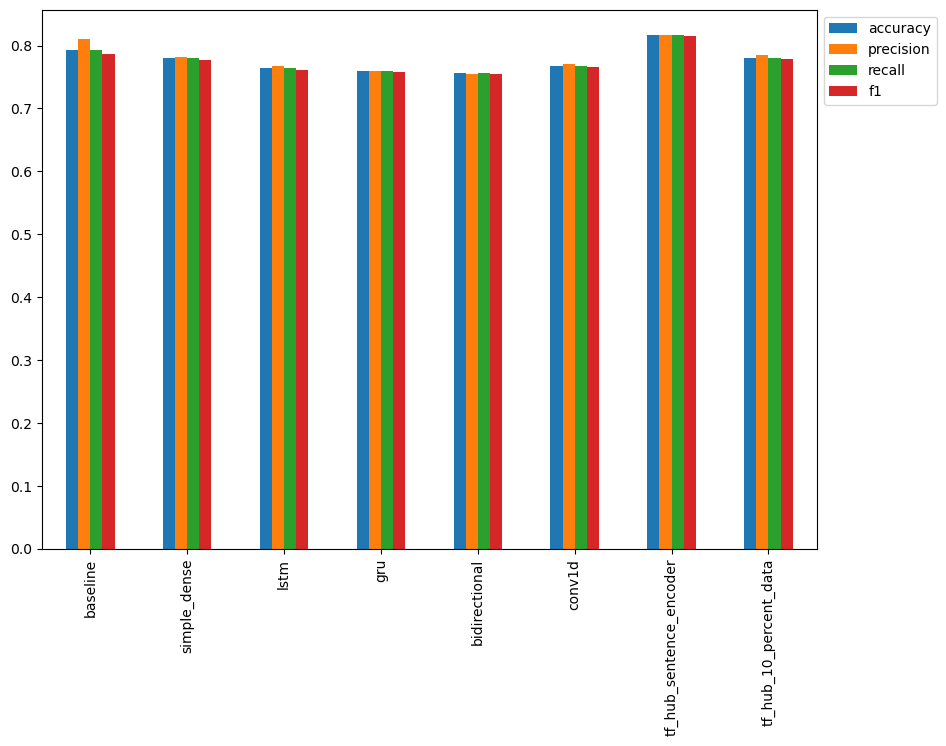

In [302]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

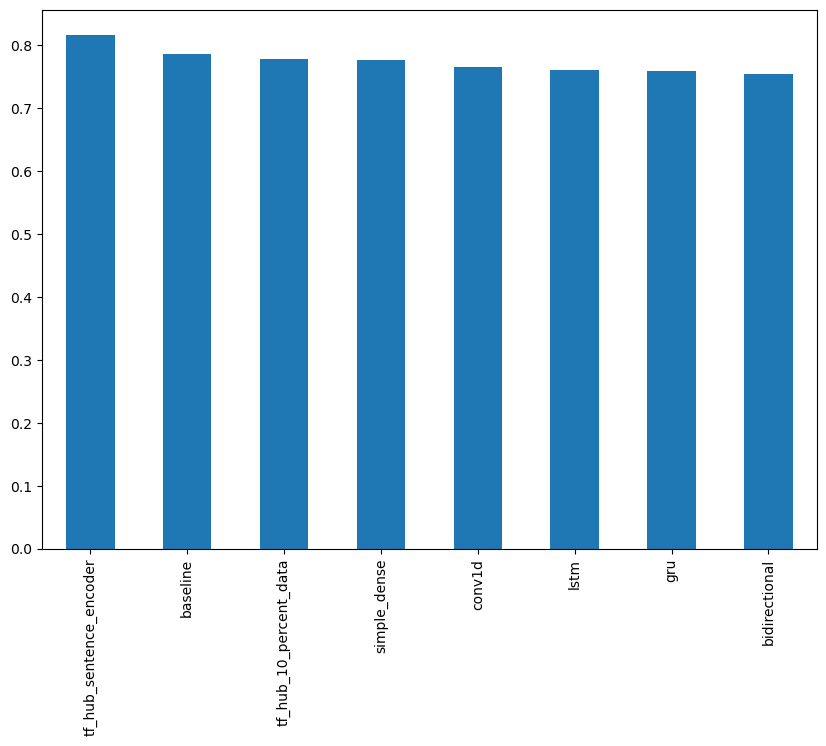

In [304]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

In [319]:
# Get mean pred for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1)
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3)
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [320]:
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 78.87139107611549,
 'precision': 0.7886601421785839,
 'recall': 0.7887139107611548,
 'f1': 0.7879587418144355}

In [321]:
all_model_results.loc["ensemble_results"] = ensemble_results

In [323]:
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

C:\Users\kajte\AppData\Local\Temp\ipykernel_20700\571815507.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100
